In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import openturns as ot
import numpy as np
import openturns.viewer as viewer

from matplotlib import pylab as plt
from matplotlib.patches import Circle, Wedge, Polygon, Rectangle
from matplotlib.collections import PatchCollection
from matplotlib.font_manager import FontProperties

import math
from functools import partial
from joblib import Parallel, delayed
import shelve
import os

import otaf

In [3]:
# HELPER FUNCTIONS
# For plotting
x_min = -0.25
x_max = 0.7
n_points = int(1e4)

# First approach for tolerance analysis with imprecise probabiltities applied on a isostatic example.

To show the benefits of this approach compared to the usual ones, we apply it using a minimal isostatic example using only a reduced number of variables and having an analytical solution. As explained, the analysis consists of 6 steps : 
 - The definition of the mathematical model from the the parts plans. 
 - The construction of the deviation domain for each toleranced feature
 - The construction of the probabilistic model using some quality criteria (sigma/6t smthing)
 - The generation of the design of experiment
 - The propagation of the uncertainty through the model.
 - The extraction of the upper and lower envelope of the response of the model. 

#### Exploring the imprecise probability space. 

For the male piece, we know that in 95% of the cases, the value of X1 will be between X1 - X_tot < X1 < X1 + X_tol ,
but the uncertainty is originating from a combination of positional and orientation defects. We do  not know which is contributing more. 

Let's first explore how the sum of the defects behaves, when under the constraint of the 95%

Let's consider that the real measure of X1 is based on a base value and a sum of random modes:

$$
X_{1} = X1 + \mathcal{e}_{pos} + \mathcal{e}_{ori} \\
\mathcal{e}_{pos} + \mathcal{e}_{ori} <= X_{tol} \ (Dans\ 95\%\ des\ cas)
$$

![schema](../SCHEMAS/SchemaModeleJeuxTolerance.png)

In [4]:
### Different measures of our problem
X1 = 99.8  # Nominal Length of the male piece
X2 = 100  # Nominal Length of the female piece
X3 = 10.0  # Nominal width of the pieces
j = X2 - X1  # Nominal play between pieces.
T = 0.2  # Tolerance for X1 and X2. (95% conform)  (= t/2)
t_ = T / 2

In [5]:
Cm = 1

sigma_e_pos_max = T / (6 * Cm)
e_pos = ot.Normal(0, sigma_e_pos_max)
e_pos.setDescription(["e_pos"])

# Le défaut en orientation est piloté par une incertitude sur un angle. On suppose les angles petits << 1 rad
theta_max = T / X3
sigma_theta_max = (2 * theta_max) / (
    6 * Cm
)  # 2* theta max!!!! A cause de l'intervalle + / - !!!!!norma
e_theta = ot.Normal(0, sigma_theta_max)
e_theta.setDescription(["e_theta"])

e_ori = (e_theta * X3) / 2
e_ori = e_ori.abs()
e_ori.setDescription(["e_ori"])

In [6]:
def analytical_assembly_model_1_5_D(rdv, rnd=6):
    """
    Calculate the minimum difference between the upper and lower gaps for a given set of defects.

    Parameters:
        rdv ot.Sample: random deviation vector in the form of a openturns Sample
        rnd (int, optional): Number of decimal places to round the result (default: 6).

    Returns:
        list: A list containing the minimum play/gap for each point in the random deviation array.

    """
    size = rdv.getSize()
    desc = rdv.getDescription()
    nzs1 = np.zeros((size, 1))
    smpU1 = np.array(rdv.getMarginal(["u_d_1"])) if "u_d_1" in desc else nzs1
    smpG1 = np.array(rdv.getMarginal(["gamma_d_1"])) if "gamma_d_1" in desc else nzs1
    smpU2 = np.array(rdv.getMarginal(["u_d_2"])) if "u_d_2" in desc else nzs1
    smpG2 = np.array(rdv.getMarginal(["gamma_d_2"])) if "gamma_d_2" in desc else nzs1

    X1_tilde = np.asarray(
        [X1 + smpU1 - (X3 / 2) * smpG1, X1 + smpU1 + (X3 / 2) * smpG1]  # haut
    ) 

    X2_tilde = np.asarray(
        [X2 - smpU2 - (X3 / 2) * smpG2, X2 - smpU2 + (X3 / 2) * smpG2]  # bas
    )
    jeu = X2_tilde - X1_tilde
    jeu_min = np.expand_dims(np.squeeze(jeu.min(axis=0)), axis=1).round(rnd).tolist()
    return ot.Sample(jeu_min)

0.0013498980316301035
0.0013498980316301035


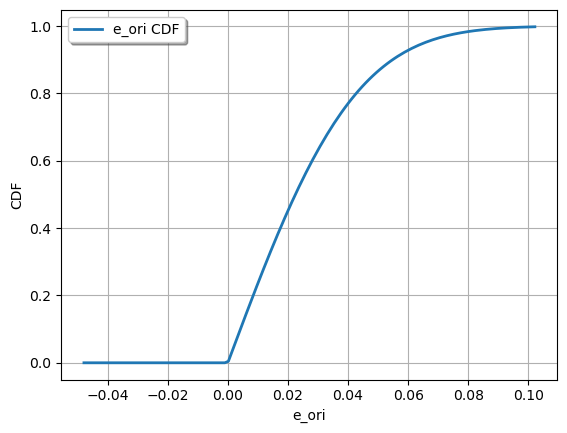

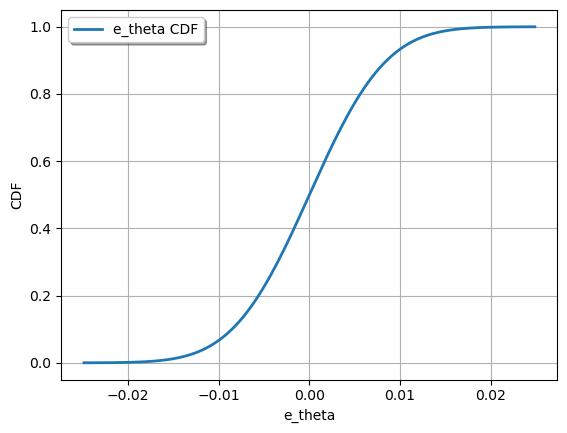

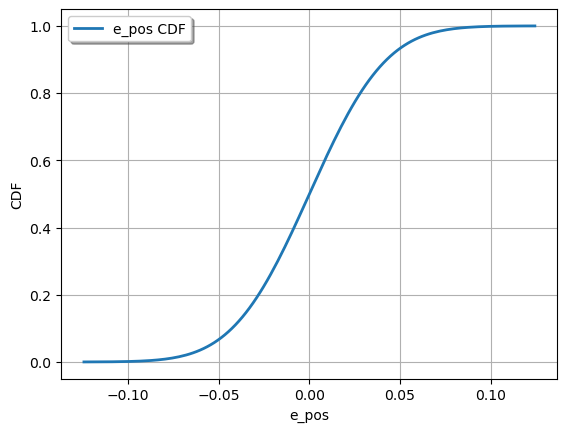

In [7]:
print(1 - e_theta.computeCDF(theta_max))
print(1 - e_pos.computeCDF(T / 2))

ot.Show(e_ori.drawCDF())
ot.Show(e_theta.drawCDF())
ot.Show(e_pos.drawCDF())

## Only defects on one feature of one part (no interaction between parts yet)

### Direct method on distributions using openturns

In [8]:
lambda_1, lambda_2 = 1, 0
# Limit cases
j_lim1 = X2 - e_pos - X1  # Cas limite 1, seulement erreur en position
j_lim2 = X2 - e_ori - X1  # Cas limite 2, seulement erreur en orientation
j_lim3 = (X2 - (np.sqrt(0.5) * e_pos + np.sqrt(0.5) * e_ori) - X1)

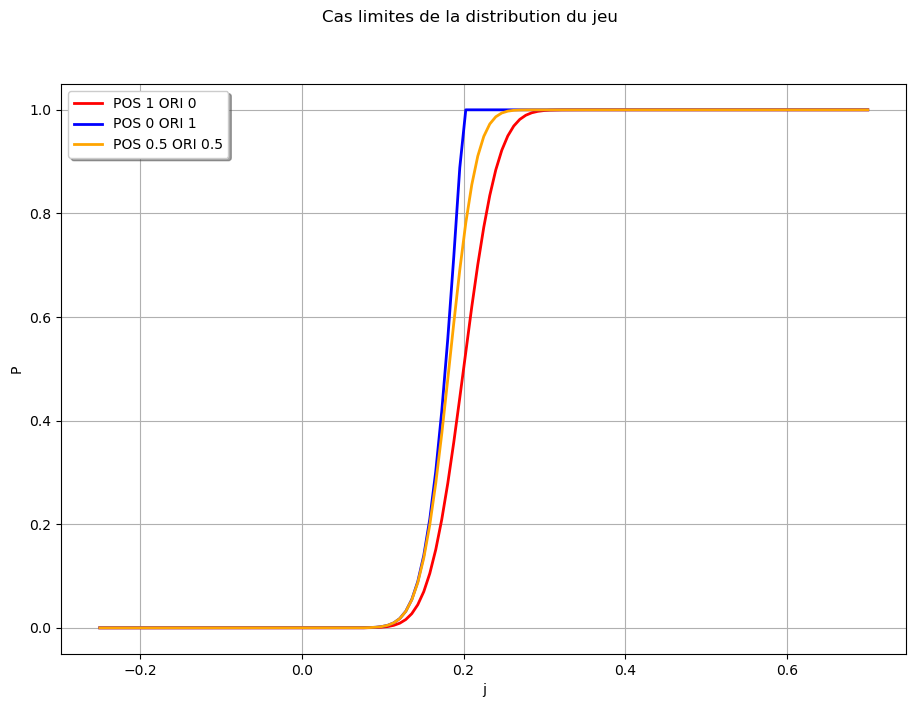

In [9]:
graph = j_lim1.drawCDF(x_min, x_max)
graph = otaf.plotting.set_graph_legends(
    graph, x_title="j", y_title="P", title="Cas limites de la distribution du jeu"
)
graph.add(j_lim2.drawCDF(x_min, x_max))
graph.add(j_lim3.drawCDF(x_min, x_max))
graph = otaf.plotting.set_graph_legends(
    graph,
    legends=["POS 1 ORI 0", "POS 0 ORI 1", "POS 0.5 ORI 0.5"],
    colors=["red", "blue", "orange"],
)
view = ot.viewer.View(graph, pixelsize=(1100, 750))

### Sampling based estimation of the distribution with only defects on one feature, and an imprecise defect allocation

In [10]:
size_lambda1 = 100
size_MC1 = int(1e3)

lambda_1_smp_base = np.array(list(range(size_lambda1 + 1))) / size_lambda1
lambda_1_smp = ot.Sample(np.array([np.sqrt(lambda_1_smp_base), np.sqrt(1-lambda_1_smp_base)]).T) # sqrt cause multiplication of distribution with constant

In [11]:
ot.RandomGenerator.SetSeed(888)

RandDeviationVect = otaf.distribution.get_composed_normal_defect_distribution(
    defect_names=["gamma_d_1", "u_d_1"],
    sigma_dict={"gamma_": sigma_theta_max, "u_": sigma_e_pos_max},
)

sample_base_1Feature = RandDeviationVect.getSample(size_MC1)
sample_composed_1Feature = otaf.sampling.compose_defects_with_lambdas(lambda_1_smp, sample_base_1Feature)
sample_gap_1Feature = [analytical_assembly_model_1_5_D(_X) for _X in sample_composed_1Feature]
distributions_1Feature = list(map(ot.UserDefined, sample_gap_1Feature))

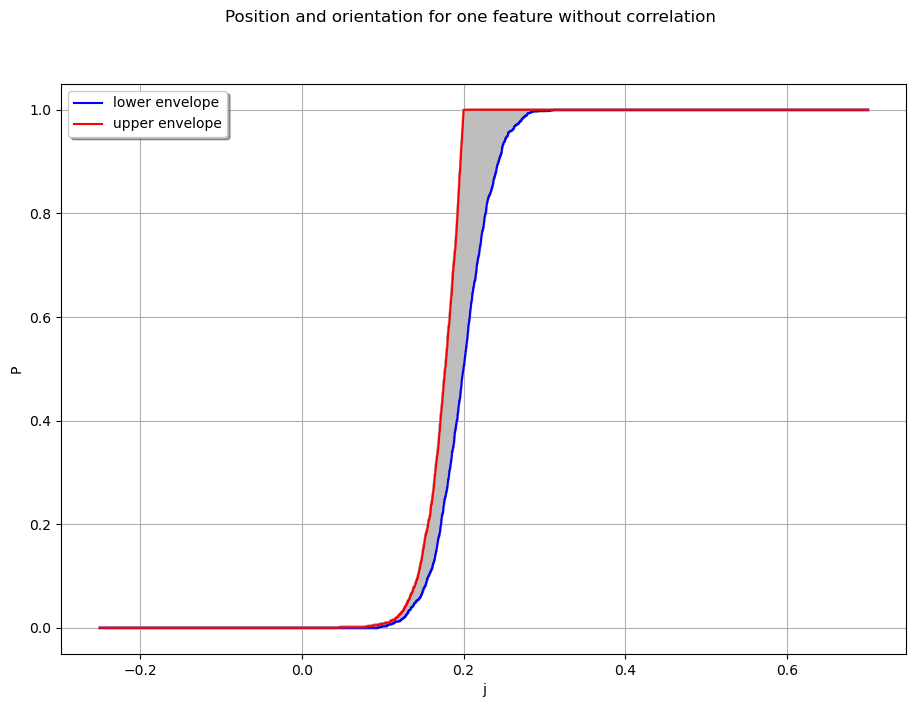

In [12]:
colors1 = [["grey"]] * lambda_1_smp.getSize()
legends1 = [""] * lambda_1_smp.getSize()

sup_data1, inf_data1 = otaf.distribution.compute_sup_inf_distributions(distributions_1Feature, x_min, x_max)

graph_full_1 = otaf.plotting.plot_combined_CDF(distributions_1Feature, x_min, x_max, colors1, legends1)

graph_full_1 = otaf.plotting.set_graph_legends(
    graph_full_1,
    x_title="j",
    y_title="P",
    title="Position and orientation for one feature without correlation",
    legends=[""] * len(distributions_1Feature),
)

graph_full_1.add(ot.Curve(inf_data1, "blue", "solid", 1.5, "lower envelope"))
graph_full_1.add(ot.Curve(sup_data1, "red", "solid", 1.5, "upper envelope"))

view = ot.viewer.View(graph_full_1, pixelsize=(1100, 750))

In [13]:
sup_data1
inf_data1
get_prob_0 = lambda X: X[np.squeeze(np.argwhere(np.abs(X[:, 0]) < 1e-4))]
print(get_prob_0(sup_data1)[:, 1].max(), get_prob_0(inf_data1)[:, 1].max())

0.0 0.0


# Defects defined for both parts/features. All defects still independent.

In [14]:
# Model the imprecise space of defect allocation with 2 features and 4 DOFs
# i corresponds to the first feature, j corresponds to the second feature
size_lambda = 7
idar = np.arange(size_lambda + 1)
lambda_2_ar = np.vstack([idar / size_lambda, 1 - idar / size_lambda]).T

# Generate all possible allocation combinations and compute their square roots
ij_list = np.sqrt(np.array([[np.append(lambda_2_ar[i], lambda_2_ar[j]) for i in idar] for j in idar]).reshape(-1, 4))

# Create a sample using OpenTURNS
lambda_2_smp = ot.Sample(ij_list)

In [15]:
# Monte Carlo sample size and random generator seed
size_MC2 = int(1e6)
ot.RandomGenerator.SetSeed(888)

# Get the composed normal defect distribution
RandDeviationVect = otaf.distribution.get_composed_normal_defect_distribution(
    defect_names=["gamma_d_1", "u_d_1", "gamma_d_2", "u_d_2"],
    sigma_dict={"gamma_": sigma_theta_max, "u_": sigma_e_pos_max}
)

# Sample from the random deviation vector
rdvx2 = RandDeviationVect.getSample(size_MC2)

# Compose the defect samples with the lambda samples
rdvxld_l2 = otaf.sampling.compose_defects_with_lambdas(lambda_2_smp, rdvx2)

# Compute the gap list and corresponding distributions
gapLst2 = [analytical_assembly_model_1_5_D(rdvxld) for rdvxld in rdvxld_l2]
distributions2 = [ot.UserDefined(gap) for gap in gapLst2]

In [16]:
# Helper functions for lambda position and formatting strings
get_pos_lambda = lambda i, ar: [ar[i, 1], ar[i, 3]]  # Extract specific lambda positions
get_lambda_str = lambda l: f"Allocation position piece 1: {l[0] * 100:.1f}%, piece 2: {l[1] * 100:.1f}%"

# Define interesting pairs of lambda values and their colors
pos_pairs = [[0.0, 0.0], [0.0, 1.0], [1.0, 0.0], [0.2, 0.8], [0.8, 0.2], [1.0, 1.0]]
pos_pair_cols = [["#FF00CD"], ["green"], ["orange"], ["#00FFF3"], ["yellow"], ["black"]]

# Find the indices corresponding to the interesting lambda pairs
pos_pair_idx = [i for i in range(len(ij_list)) if get_pos_lambda(i, ij_list) in pos_pairs]

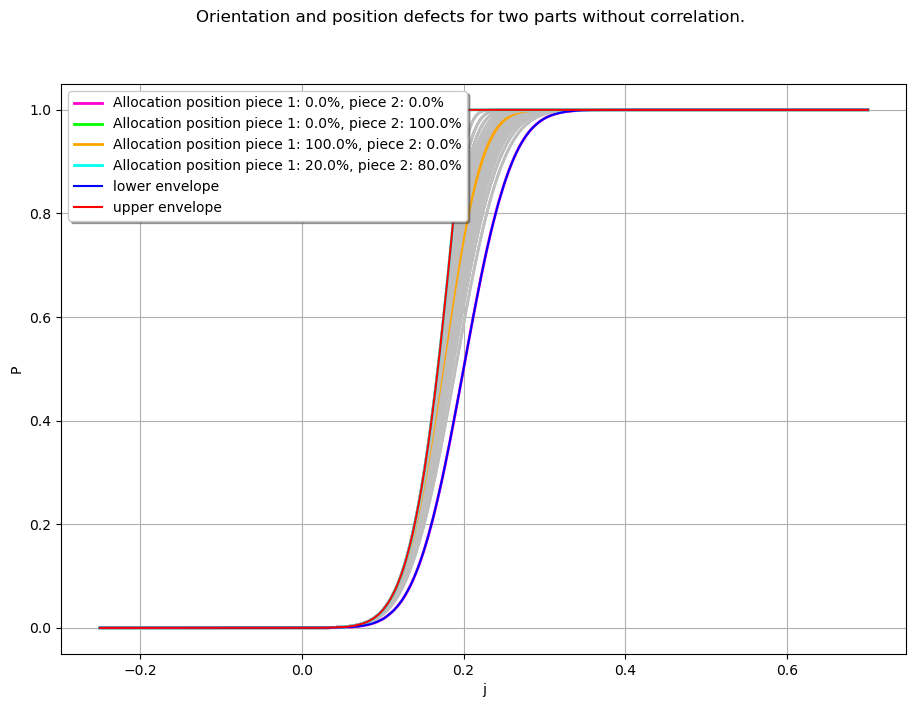

In [17]:
# Initialize colors and legends for each lambda sample
colors2 = [["grey"]] * lambda_2_smp.getSize()
legends2 = [""] * lambda_2_smp.getSize()

# Set colors and legends for interesting lambda pairs
for i, k in enumerate(pos_pair_idx):
    colors2[k] = pos_pair_cols[i]
    legends2[k] = get_lambda_str(pos_pairs[i])

# Compute the upper and lower envelopes of the distributions
sup_data2, inf_data2 = otaf.distribution.compute_sup_inf_distributions(distributions2, x_min, x_max)

# Plot the combined CDF with additional curves for the envelopes
graph_full_2 = otaf.plotting.plot_combined_CDF(distributions2, x_min, x_max, colors2, legends2)
graph_full_2 = otaf.plotting.set_graph_legends(
    graph_full_2,
    x_title="j",
    y_title="P",
    title="Orientation and position defects for two parts without correlation.",
    legends=legends2
)

# Add the upper and lower envelopes to the graph
graph_full_2.add(ot.Curve(inf_data2, "blue", "solid", 1.5, "lower envelope"))
graph_full_2.add(ot.Curve(sup_data2, "red", "solid", 1.5, "upper envelope"))

# Display the final graph
view = ot.viewer.View(graph_full_2, pixelsize=(1100, 750))

Text(0.5, 1.0, 'Probability-Box of the Gap G with Imprecise Allocation and Independence')

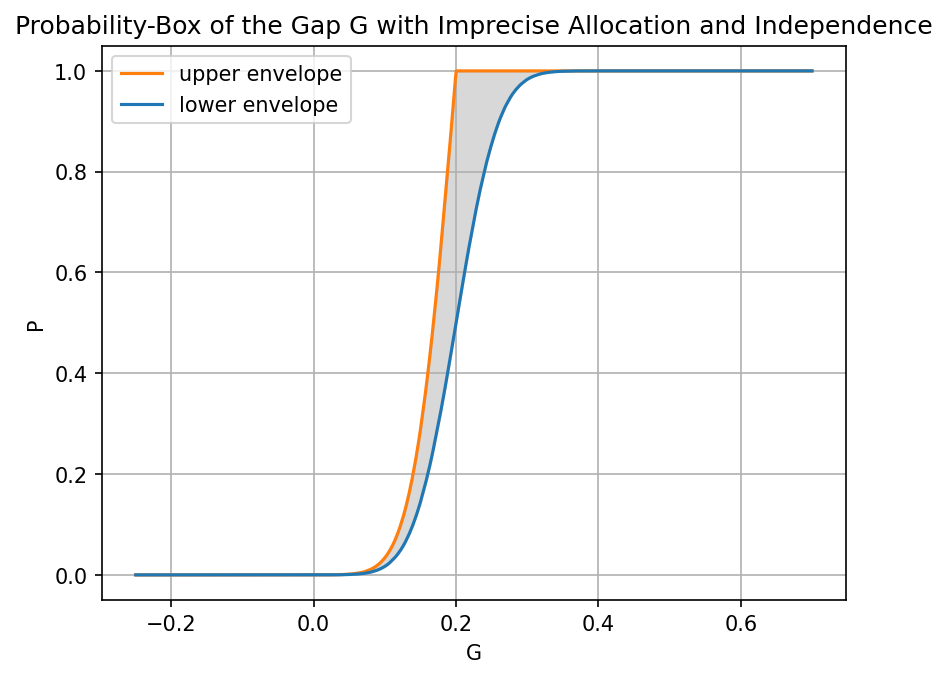

In [18]:
# %matplotlib qt
fig3 = plt.figure(dpi=150)

ax3 = fig3.add_subplot(1, 1, 1)
ax3.plot(sup_data2[:, 0], sup_data2[:, 1], color="tab:orange", label="upper envelope")
ax3.plot(inf_data2[:, 0], inf_data2[:, 1], color="tab:blue", label="lower envelope")
ax3.grid(True)
ax3.fill_between(
    inf_data2[:, 0], inf_data2[:, 1], sup_data2[:, 1], color="gray", alpha=0.3
)
ax3.set_xlabel("G")
ax3.set_ylabel("P")
ax3.legend()
ax3.set_title("Probability-Box of the Gap G with Imprecise Allocation and Independence")

In [20]:
print("Lower probability of failure:", round(otaf.distribution.get_prob_below_threshold(inf_data2)), "%")
print("Upper probability of failure:", round(otaf.distribution.get_prob_below_threshold(sup_data2)), "%")

Lower probability of failure: 0 %
Upper probability of failure: 0 %


In [22]:
print(f"Minimum failure probability: {otaf.distribution.get_prob_below_threshold(inf_data2):.5e}, Maximum failure probability: {otaf.distribution.get_prob_below_threshold(sup_data2):.5e}")

Minimum failure probability: 6.00000e-06, Maximum failure probability: 2.90000e-05


In [ ]:
qzrgq

In [ ]:
otaf.plotting.save_plot(filename="PBoxGapGImpreciseAllocationIndependence", ax=ax3, dpi=600)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create the new figure
fig_overlap = plt.figure(dpi=600)
ax_overlap = fig_overlap.add_subplot(1, 1, 1)

# Plot the upper and lower envelopes for both correlation and independence
ax_overlap.plot(sup_data2[:, 0], sup_data2[:, 1], color="tab:green", label="upper envelope (Independence)")
ax_overlap.plot(inf_data2[:, 0], inf_data2[:, 1], color="tab:green", linestyle='--', label="lower envelope (Independence)")

ax_overlap.plot(sup_data3[:, 0], sup_data3[:, 1], color="tab:red", label="upper envelope (Correlation)")
ax_overlap.plot(inf_data3[:, 0], inf_data3[:, 1], color="tab:red", linestyle='--', label="lower envelope (Correlation)")

# Grid
ax_overlap.grid(True)

# Define arrays for gap values and bounds
g_vals = sup_data2[:, 0]
li = inf_data2[:, 1]  # Lower bound for Independence
lc = inf_data3[:, 1]  # Lower bound for Correlation
ui = sup_data2[:, 1]  # Upper bound for Independence
uc = sup_data3[:, 1]  # Upper bound for Correlation

# Masks for the different regions
# Green: Independence dominates (li < lc) or (ui > uc)
mask_green_lower = li < lc
mask_green_upper = ui > uc

# Red: Correlation dominates (lc < li) or (uc > ui)
mask_red_lower = lc < li
mask_red_upper = uc > ui

# Gray: Overlapping regions (li < uc) and (lc < ui)
mask_gray = (li < uc) & (lc < ui)

# Fill regions based on the masks
# Green regions
ax_overlap.fill_between(g_vals, li, lc, where=mask_green_lower, color="green", alpha=0.3)
ax_overlap.fill_between(g_vals, uc, ui, where=mask_green_upper, color="green", alpha=0.3)

# Red regions
ax_overlap.fill_between(g_vals, lc, li, where=mask_red_lower, color="red", alpha=0.3)
ax_overlap.fill_between(g_vals, ui, uc, where=mask_red_upper, color="red", alpha=0.3)

# Gray regions (overlap)
ax_overlap.fill_between(g_vals, np.maximum(li, lc), np.minimum(ui, uc), where=mask_gray, color="gray", alpha=0.3)

# Set labels and title
ax_overlap.set_xlabel("G")
ax_overlap.set_ylabel("P")
ax_overlap.set_title("Overlapping Probability-Box of the Gap G with Imprecise Allocation")

# Add legend
ax_overlap.legend()

# Show the plot
plt.show()


In [ ]:
otaf.plotting.save_plot(filename="PBoxGapGImpreciseAllocationIndependenceCorrelationOverlap", ax=ax_overlap, dpi=600)

# Adding Correlations Between defects within features

Adding correlations between random variables introduces additional dimensions of imprecision. For `d` imperfections modeled and influenced by `λ` (lambda) coefficients, we can define `d-1` correlations if we wish to model them.

In [ ]:
# Monte Carlo sample size and lambda/correlation settings
size_monte_carlo = int(1e5)

# Lambda sampling: creating a base array for the lambda space
size_lambda = 5
lambda_array = np.linspace(0, 1, size_lambda + 1)  # Simplified sampling of lambda space

# Correlation sampling: evenly spaced between -1 and 1
size_correlation = 5
correlation = np.linspace(-1 + 1e-7, 1 - 1e-7, size_correlation)  # Avoiding perfect correlation values

In [ ]:
# Create a 4D grid of lambda and correlation combinations
lambda_indices = list(range(size_lambda + 1))
correlation_indices = list(range(size_correlation))

# Generate all combinations of lambda and correlation pairs
ijkz_list = np.array([
    [
        [
            [
                np.append([lambda_array[i], lambda_array[j]], [correlation[k], correlation[z]])
                for i in lambda_indices
            ]
            for j in lambda_indices
        ]
        for k in correlation_indices
    ]
    for z in correlation_indices
])

# Reshape the resulting array to create a combined lambda-correlation sample
ijkz_list = ijkz_list.reshape(-1, 4)  # Reshaping into a 2D array with 4 columns (λ₁, λ₂, correlation₁, correlation₂)

In [ ]:
def compute_gap_with_lambdas_and_correlation(
    lmbd1, lmbd2, cor1, cor2, 
    lmb_arr=lambda_array, correlation=correlation, 
    SEED=888, N=size_monte_carlo
):
    """
    Compute the gap between two tilde values, influenced by lambda coefficients and correlations.
    
    Parameters:
    -----------
    lmbd1 : float
        Lambda value for the first sample.
    lmbd2 : float
        Lambda value for the second sample.
    cor1 : float
        Correlation coefficient for the first sample.
    cor2 : float
        Correlation coefficient for the second sample.
    lmb_arr : np.array
        Array of lambda values (default: lambda_array).
    correlation : np.array
        Array of correlation values (default: correlation).
    SEED : int
        Random seed for reproducibility.
    N : int
        Monte Carlo sample size.

    Returns:
    --------
    ot.Sample
        A sample of the computed gaps between X1_tilde and X2_tilde.
    """
    
    # Set random seed for reproducibility
    ot.RandomGenerator.SetSeed(SEED)
    
    # Generate correlated samples for both sets of imperfections
    smp1 = otaf.distribution.generate_correlated_samples(
        sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, N=N, corr=cor1
    )
    smp2 = otaf.distribution.generate_correlated_samples(
        sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, N=N, corr=cor2
    )
    
    # Extract positional and angular deviations
    e_pos_X1, e_theta1 = np.squeeze(smp1[:, 0]), np.squeeze(smp1[:, 1])
    e_pos_X2, e_theta2 = np.squeeze(smp2[:, 0]), np.squeeze(smp2[:, 1])
    
    # Compute X1_tilde and X2_tilde based on the lambda coefficients and deviations
    X1_tilde = np.array([
        X1 + np.sqrt(lmbd1) * e_pos_X1 - np.sqrt(1 - lmbd1) * (X3 / 2) * e_theta1,
        X1 + np.sqrt(lmbd1) * e_pos_X1 + np.sqrt(1 - lmbd1) * (X3 / 2) * e_theta1,
    ])
    
    X2_tilde = np.array([
        X2 - np.sqrt(lmbd2) * e_pos_X2 - np.sqrt(1 - lmbd2) * (X3 / 2) * e_theta2,
        X2 - np.sqrt(lmbd2) * e_pos_X2 + np.sqrt(1 - lmbd2) * (X3 / 2) * e_theta2,
    ])
    
    # Compute the gap (jeu) between X2_tilde and X1_tilde
    jeu = X2_tilde - X1_tilde
    jeu = np.expand_dims(np.squeeze(jeu.min(axis=0)), axis=1)
    
    # Return the result as an OpenTURNS sample
    return ot.Sample(jeu)


# Create a partial function with fixed parameters for lambda_array, correlation, and Monte Carlo size
compute_gap_func = partial(
    compute_gap_with_lambdas_and_correlation, 
    lmb_arr=lambda_array, correlation=correlation, 
    SEED=168406047, N=size_monte_carlo
)

# Apply the function to each combination in the lambda-correlation grid
ijkz_results = Parallel(n_jobs=-1)(delayed(compute_gap_func)(i, j, k, z) for i, j, k, z in ijkz_list)

In [ ]:
# Create distributions from the results of the gap function
#distributions3 = list(map(ot.UserDefined, ijkz_results))
distributions3 = Parallel(n_jobs=-1)(delayed(ot.UserDefined)(result) for result in ijkz_results)

# Initialize color and legend settings for each result
colors3 = [["grey"] for _ in ijkz_results]
legends3 = ["" for _ in ijkz_results]

# Compute the supremum and infimum data from the distributions
sup_data3, inf_data3 = otaf.distribution.compute_sup_inf_distributions(distributions3, x_min, x_max)

# Create a combined CDF graph for the distributions
graph_full_3 = otaf.plotting.plot_combined_CDF(distributions3, x_min, x_max, colors3, legends3)

# Set the title and legends for the graph
title = "Probability-Box of the Gap G with Imprecise Allocation and Correlation"
graph_full_3 = otaf.plotting.set_graph_legends(
    graph_full_3, 
    x_title="G", 
    y_title="P", 
    title=title, 
    legends=[""] * len(ijkz_results)
)

# Add the lower and upper envelopes (infimum and supremum) to the graph
graph_full_3.add(ot.Curve(inf_data3, "blue", "solid", 1.5, "lower envelope"))
graph_full_3.add(ot.Curve(sup_data3, "red", "solid", 1.5, "upper envelope"))

# Display the graph
view = ot.viewer.View(graph_full_3, pixelsize=(1100, 750))


In [ ]:
# %matplotlib qt
fig31 = plt.figure(dpi=150)

ax31 = fig31.add_subplot(1, 1, 1)
ax31.plot(sup_data3[:, 0], sup_data3[:, 1], color="tab:orange", label="upper envelope")
ax31.plot(inf_data3[:, 0], inf_data3[:, 1], color="tab:blue", label="lower envelope")
ax31.grid(True)
ax31.fill_between(
    inf_data3[:, 0], inf_data3[:, 1], sup_data3[:, 1], color="gray", alpha=0.3
)
ax31.set_xlabel("G")
ax31.set_ylabel("P")
ax31.legend()
ax31.set_title("Probability-Box of the Gap G with Imprecise Allocation and Correlation")

In [ ]:
print("Lower probability of failure:", round(otaf.distribution.get_prob_below_threshold(inf_data3) * 100, 9), "%")
print("Upper probability of failure:", round(otaf.distribution.get_prob_below_threshold(sup_data3) * 100, 9), "%")

In [ ]:
otaf.plotting.save_plot(filename="PBoxGapGImpreciseAllocationCorrelation", ax=ax31, dpi=600)

# Modify the way we create the experimental design to explore the imprecise space (lambda and correlation)

### We will use Latin Hypercube Sampling (LHS) for this purpose.

##### First, we define distributions to represent the uncertainties.

In [ ]:
# Define uniform distributions for lambda and correlation values
lambda_12_dist = ot.Uniform(0, 1)
lambda_34_dist = ot.Uniform(0, 1)
correlation_dist12 = ot.Uniform(-1, 1)
correlation_dist34 = ot.Uniform(-1, 1)

# Combine these into a composed distribution
composed_dist = ot.ComposedDistribution(
    [lambda_12_dist, lambda_34_dist, correlation_dist12, correlation_dist34]
)

#### We generate the LHS in the normal space and use the isoprobabilistic transformation to map it back to the original space.


In [ ]:
ot.RandomGenerator.SetSeed(123456789)
SIZE_LHS = 100
lhsExp = ot.LHSExperiment(composed_dist, SIZE_LHS, False, True)
lhs_sample = lhsExp.generate()

In [ ]:
# Modified mini_func4 without storing in shelve
def compute_gap_with_lambdacor(id_, lambdacor, N=size_monte_carlo):
    lb1, lb3, C1, C2 = lambdacor

    # Set the random seed for reproducibility
    ot.RandomGenerator.SetSeed(999)

    # Generate correlated samples for the first and second sets of imperfections
    smp1 = otaf.distribution.generate_correlated_samples(
        sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, corr=C1, N=N
    )
    smp2 = otaf.distribution.generate_correlated_samples(
        sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, corr=C2, N=N
    )

    # Extract positional and angular deviations
    e_pos_X1, e_theta1 = np.squeeze(smp1[:, 0]), np.squeeze(smp1[:, 1])
    e_pos_X2, e_theta2 = np.squeeze(smp2[:, 0]), np.squeeze(smp2[:, 1])

    # Compute X1_tilde and X2_tilde based on the lambda coefficients and deviations
    X1_tilde = np.array([
        X1 + np.sqrt(lb1) * e_pos_X1 - np.sqrt(1 - lb1) * (X3 / 2) * e_theta1,
        X1 + np.sqrt(lb1) * e_pos_X1 + np.sqrt(1 - lb1) * (X3 / 2) * e_theta1,
    ])
    
    X2_tilde = np.array([
        X2 - np.sqrt(lb3) * e_pos_X2 - np.sqrt(1 - lb3) * (X3 / 2) * e_theta2,
        X2 - np.sqrt(lb3) * e_pos_X2 + np.sqrt(1 - lb3) * (X3 / 2) * e_theta2,
    ])

    # Calculate the gap (jeu) between X2_tilde and X1_tilde
    jeu = X2_tilde - X1_tilde
    jeu = np.expand_dims(np.squeeze(jeu.min(axis=0)), axis=1)

    return ot.Sample(jeu)

# Partial function with fixed parameters
compute_gap_part4 = partial(compute_gap_with_lambdacor, N=size_monte_carlo)

# Generate the samples using compute_gap_part4
samples4 = [compute_gap_part4(id_, lambdacor) for id_, lambdacor in enumerate(lhs_sample)]

In [ ]:
# Create UserDefined distributions based on the samples
distributions4 = list(map(ot.UserDefined, samples4))

# Generate colors and legends for the distributions
colors4 = [["grey"] for _ in samples4]
legends4 = ["" for _ in samples4]

# Compute the supremum and infimum data for the distributions
sup_data4, inf_data4 = otaf.distribution.compute_sup_inf_distributions(distributions4, x_min, x_max)

# Create a combined CDF graph for the distributions
graph_full_4 = otaf.plotting.plot_combined_CDF(distributions4, x_min, x_max, colors4, legends4)

# Set the graph titles and legends
graph_full_4 = otaf.plotting.set_graph_legends(
    graph_full_4,
    x_title="j",
    y_title="P",
    title="Orientation and position defects for two parts. With correlation. Imprecision driven by LHS",
    legends=[""] * len(samples4),
)

# Add the lower and upper envelopes to the graph
graph_full_4.add(ot.Curve(inf_data4, "blue", "solid", 1.5, "lower envelope"))
graph_full_4.add(ot.Curve(sup_data4, "red", "solid", 1.5, "upper envelope"))

# Display the graph
view = ot.viewer.View(graph_full_4, pixelsize=(1100, 750))

In [ ]:
graph_all = ot.Graph(
    """Superposition of the different cases""", "j", "P", True, "", 1.0, 0
)
#graph_all.add(ot.Curve(inf_data1, "orange", "solid", 1.5, "lower envelope 1"))
#graph_all.add(ot.Curve(sup_data1, "orange", "solid", 1.5, "upper envelope 1"))
graph_all.add(ot.Curve(inf_data2, "green", "solid", 1.5, "lower envelope 2"))
graph_all.add(ot.Curve(sup_data2, "green", "solid", 1.5, "upper envelope 2"))
graph_all.add(ot.Curve(inf_data3, "red", "solid", 1.5, "lower envelope 3"))
graph_all.add(ot.Curve(sup_data3, "red", "solid", 1.5, "upper envelope 3"))
#graph_all.add(ot.Curve(inf_data4, "blue", "solid", 1.5, "lower envelope 4"))
#graph_all.add(ot.Curve(sup_data4, "blue", "solid", 1.5, "upper envelope 4"))
graph_all.add(ot.Curve([0, 0], [0, 0.3], 'black'))
graph_all.setLegends(
    [
        "lower envelope 1",
        "upper envelope 1",
        "lower envelope 2",
        "upper envelope 2",
        "lower envelope 3",
        "upper envelope 3",
        "lower envelope 4",
        "upper envelope 4",
    ]
)
view = ot.viewer.View(graph_all, pixelsize=(1100, 750))

## Let's plot some deviation domains with different types of allocations and correlations. 

In [ ]:
# %matplotlib qt

In [ ]:
SIZE_LHS = 9
composed_dist_uiq = ot.ComposedDistribution([lambda_12_dist, correlation_dist12])
lhsExp_uiq = ot.LHSExperiment(composed_dist_uiq, SIZE_LHS, False, True)
lhs_arr = np.array(lhsExp_uiq.generate())
lmbds, corr = lhs_arr[:, 0], lhs_arr[:, 1]

In [ ]:
seed = 3641641648
fig, ax = plt.subplots(ncols=3, nrows=3)
idx = 0
for i in range(3):
    for j in range(3):
        ot.RandomGenerator.SetSeed(seed)
        sample =  otaf.distribution.generate_correlated_samples(sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, corr=corr[idx], N=3355)
        
        # Compute and print variance for diagnostic purposes
        var_1 = np.var(sample[:, 0])
        var_2 = np.var(sample[:, 1])
        print(f"Sample {idx}: Variance in X1 = {var_1}, Variance in X2 = {var_2}, Correlation = {corr[idx]}")
        
        otaf.plotting.print_sample_in_deviation_domain(
            ax[i, j], sample[:, 0], sample[:, 1], 
            np.sqrt(lmbds[idx]), np.sqrt(1 - lmbds[idx]), 
            t_, theta_max, ratio=1, remove_ticks=False
        )
        idx += 1

fig.set_dpi(100)
print("sigma_e_pos_max**2", sigma_e_pos_max**2)
print("sigma_theta_max**2", sigma_theta_max**2)

In [ ]:
sigma_e_pos_max**2

In [ ]:
seed = 3641641648
fig, ax = plt.subplots()  # Only one plot for testing

# Set the first element of the sequences for testing
idx = 0  # First element of sequences
ot.RandomGenerator.SetSeed(seed)

# Generate one sample with the first values of sigma and correlation
sample = otaf.distribution.generate_correlated_samples(
    sigma1=sigma_e_pos_max, sigma2=sigma_theta_max, corr=0, N=3355 #
)

sample_pos = e_pos.getSample(3355)
sample_theta = e_theta.getSample(3355)

# Compute and print variance for diagnostic purposes
var_1 = np.var(sample[:, 0])
var_2 = np.var(sample[:, 1])
print(f"Sample {idx}: Variance in X1 = {var_1}, Variance in X2 = {var_2}, Correlation = {corr[idx]}")

# Plot the sample in the deviation domain using the first parameters
otaf.plotting.print_sample_in_deviation_domain(
    ax, sample_pos, sample_theta, 
    np.sqrt(lmbds[idx]), np.sqrt(1 - lmbds[idx]), 
    t_, theta_max, ratio=1, remove_ticks=False
)

# Adjust figure DPI for better resolution
fig.set_dpi(100)

# Print the squared sigma values for diagnostic purposes
print("sigma_e_pos_max**2", sigma_e_pos_max**2)
print("sigma_theta_max**2", sigma_theta_max**2)


## Let's plot the same without correlation at all 

In [ ]:
SEED=265
N8PTS = 3350 #10000#
ot.RandomGenerator.SetSeed(SEED)
sample_pos = e_pos.getSample(N8PTS)
sample_theta = e_theta.getSample(N8PTS)
lmbds2 = [0.5, 0.98, 0.02]

In [ ]:
# Ensure 'osifont' is correctly recognized
custom_font = FontProperties(family='osifont')

def plot_rect_part(ax, scaleFactor=100, rect_length=100, rect_height=10, aspect=8, custom_font=custom_font):
    """
    Plots a rectangular part with hatching, maintaining the given aspect ratio and applying
    optional custom font and size scaling.
    """
    # Create the main rectangle with hatching
    main_rect = Rectangle((0, 0), rect_length, rect_height, linewidth=2, edgecolor='black',
                                  facecolor='none', hatch='//')  # Diagonal hatching
    ax.add_patch(main_rect)
    
    # Maintain the aspect ratio
    ax.set_aspect(aspect)

    # Add the tolerance zone as a green transparent area centered around the nominal value
    tolerance_zone_x = np.array([rect_length - scaleFactor * t_, rect_length + scaleFactor * t_])
    tolerance_zone_y = np.array([rect_height, rect_height])
    ax.fill_between(tolerance_zone_x, tolerance_zone_y[0], y2=0, color='green', alpha=0.3)

    # Adding arrows with proper alignment for the tolerance zone
    ax.arrow(rect_length, rect_height + 0.5, -t_ * scaleFactor, 0, head_width=0.5, head_length=1.0,
             overhang=0.3, linewidth=2, color="r", length_includes_head=True)
    ax.arrow(rect_length, rect_height + 0.5, t_ * scaleFactor, 0, head_width=0.5, head_length=1.0,
             overhang=0.3, linewidth=2, color="r", length_includes_head=True)
    ax.text(rect_length - 5, rect_height + 0.75, f"t*{scaleFactor}", color="r",
            fontsize="x-large", fontweight="bold", fontproperties=custom_font)

    # Add label 'A' centered and aligned on the left
    ax.text(-11, rect_height * 0.5, "A", ha="center", va="center",
            fontsize="xx-large", fontweight="bold", fontproperties=custom_font,
            bbox=dict(facecolor="none", edgecolor="black", boxstyle="circle", linewidth=1.5))

    # Arrow pointing to the rectangle surface
    ax.arrow(-7, rect_height * 0.5, 6.5, 0, head_width=0.45, head_length=1.5,
             overhang=0, linewidth=1.5, color="k", length_includes_head=True)

    # Removing the grid, ticks, and bounding box
    ax.set_xticks([])#[0, rect_length])
    ax.set_yticks([])#[0, rect_height])
    ax.tick_params(left=False, bottom=False, labelsize='large')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(False)

    return ax

def plot_deviated_surfs(ax, sample_pos, sample_rot, lambda_, scaleFactor=100, rect_length=100, rect_height=10,):
    """adds on the rectangular part a ensemble of deviated lines, to
    see the geometrical distribution of the defects and the impact
    of the allocations.
    The defects are multiplied by a scaleFactor
    """
    sample_pos = np.squeeze(sample_pos)
    sample_rot = np.squeeze(sample_rot)
    x_line = np.array([rect_length, rect_length])
    y_line = np.array([rect_height, 0.0])  # stays constant

    assert len(sample_pos) == len(sample_rot), "Mismatch in position and rotation lengths."
    for i in range(len(sample_rot)):
        x_ltemp = x_line + (np.sqrt(lambda_) * sample_pos[i]) * scaleFactor
        x_ltemp[0] = x_ltemp[0] - (np.sqrt(1 - lambda_) * sample_rot[i] * 0.5 * rect_height) * scaleFactor
        x_ltemp[1] = x_ltemp[1] + (np.sqrt(1 - lambda_) * sample_rot[i] * 0.5 * rect_height) * scaleFactor
        ax.plot(x_ltemp, y_line, "b-", linewidth=1.1)

    return ax

In [ ]:
# %matplotlib qt
ncols, nrows = (3, 2)
fig, ax = plt.subplots(ncols=ncols, nrows=nrows)
scale_factor = 100
for i in range(ncols):
    axDD = otaf.plotting.print_sample_in_deviation_domain(
        ax[0, i],
        np.array(sample_pos),
        np.array(sample_theta),
        np.sqrt(lmbds2[i]),
        np.sqrt(1 - lmbds2[i]),
        t_,
        theta_max,
        ratio=1,
        r=None,
        remove_ticks=True
    )
    axRP = plot_rect_part(ax[1, i], scale_factor)
    axRP = plot_deviated_surfs(axRP, sample_pos, sample_theta, lmbds2[i], scale_factor)
plt.tight_layout()